In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from quetzal.model import stepmodel

In [3]:
model_path = '../model/'
input_path = '../input/'
output_path = '../outputs/'

In [4]:
show_plots = manual

# Generate the origin-destination Level-of-Service stack

## Load stepmodel - network

In [27]:
sm = stepmodel.read_json(model_path + 'network')

In [28]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(
    sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(
    sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys) > 0:
    print("Broken GeoDataFrames:", broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['centroids', 'footpaths', 'links', 'nodes', 'road_links', 'road_nodes', 'road_to_transit', 'zones', 'zone_to_road', 'zone_to_transit']
Successfully fixed.


## Preparation of OD-times

The pathfinders need a column "time" in the links or road_links tables to find the shortest paths. The PT pathfinder also applies a generalized boarding time (can be interpreted as a penalty for interchanging between transport carriers) and a waiting time, which is computed from the headway of PT carriers (waiting time equals half the headway (in seconds) assuming a randomly and evenly distributed arrival pattern of passengers on every PT stop).

In [29]:
sm.road_links.sample(1)

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold
index,,,,,,,,,
64049,1680040071,31260371,143.433,0.0,0.0,"LINESTRING (13.44326 52.47785, 13.44334 52.477...",residential,30,False


In [30]:
# Add route_type information
sm.road_links['route_type'] = 'car'

In [31]:
sm.links.loc[sm.links['route_type']!='bus'].sample(1)

,trip_id,a,b,link_sequence,time,route_id,agency_id,route_type,road_a,road_b,road_length,geometry,road_node_list,road_link_list
index,,,,,,,,,,,,,,
link_8146,17338_900_4,node_de:11000:900175520::3,node_de:11000:900175519::4,3,60.0,17338_900,796,tram,29918555,792057276,476.775,"LINESTRING (13.61554 52.53202, 13.61528 52.532...","[29918555, 1878957410, 59852728, 59852730, 792...","[21893, 65598, 33817, 33820]"


In [32]:
# assign distance to PT links - geometric distance, if not casted to road network
if not 'length' in sm.links.columns:
    sm.links['length'] = sm.links['road_length']
    mask = sm.links['length'].isna()
    sm.links.loc[mask, 'length'] = sm.links.loc[mask, 'geometry'].apply(
        lambda l: geodesic(l.coords[0], l.coords[-1]).m)

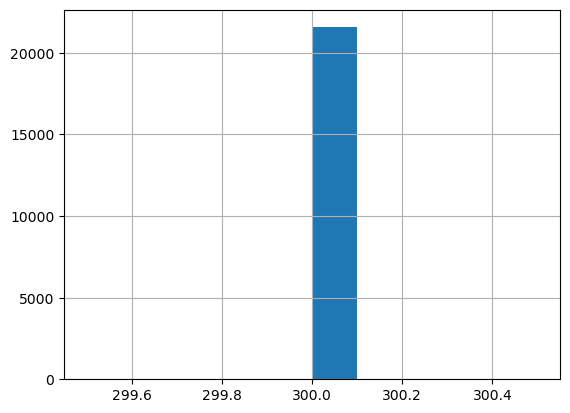

In [33]:
# add a headway for the pathfinder
# default to 5 minutes
if not 'headway' in sm.links.columns:
    sm.links['headway'] = 5*60
if show_plots: sm.links['headway'].hist()

### add speed information to road link

#### fixing broken 'maxspeed' column as it contains None, strings not convertable to numbers and lists 

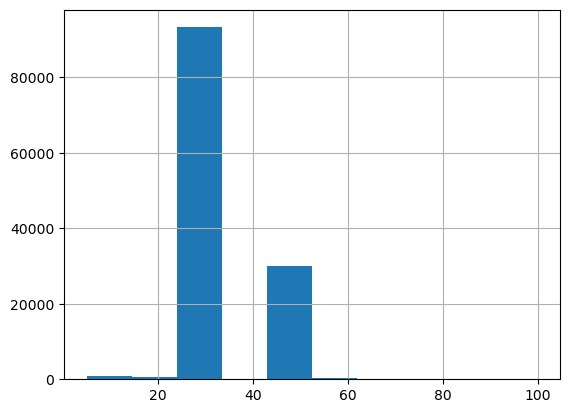

In [34]:
default_speed = np.nan
def get_vmax(s):
    v_max = default_speed
    if isinstance(s, list):
        try:
            v_max = int(max([i for i in s if i!='walk']))
        except ValueError:
            pass
    elif isinstance(s, str):
        if s=='walk':
            v_max = 5
        else:
            try:
                v_max = int(s)
            except ValueError:
                pass
    elif isinstance(s, int):
        v_max = s
    return v_max
sm.road_links["maxspeed"] = sm.road_links["maxspeed"].apply(get_vmax)
if show_plots: sm.road_links['maxspeed'].hist()

In [35]:
allHighwayTypes = []

for val in sm.road_links['highway'].values:
    if type(val) == list:
        for v in val:
            if not v in allHighwayTypes:
                allHighwayTypes.append(v)
    elif not val in allHighwayTypes:
        allHighwayTypes.append(val)

print(allHighwayTypes)

['secondary', 'tertiary', 'residential', 'primary', 'primary_link', 'motorway_link', 'motorway', 'unclassified', 'secondary_link', 'living_street', 'trunk', 'tertiary_link', 'trunk_link', 'road', 'razed']


In [36]:
# Correct speed limits
for highway_type in allHighwayTypes:
    mask = sm.road_links['highway']==highway_type
    if len(sm.road_links.loc[mask]) > 1:
        sm.road_links.loc[(mask)&(sm.road_links['maxspeed'].isna()), 'maxspeed'] = \
            sm.road_links.loc[(mask)&(sm.road_links['maxspeed'].notna()), 'maxspeed'].mean()
sm.road_links['maxspeed'].fillna(10, inplace=True)

In [37]:
speed_dict = {30: 25, 80: 70, 100: 90}
speed_reduction = .7
assert len(sm.road_links[sm.road_links['maxspeed'].isna()]) == 0

In [38]:
# Set average speed
sm.road_links['avspeed'] = sm.road_links['maxspeed'].apply(
    lambda speed: speed_dict[speed] if speed in speed_dict.keys() else speed * speed_reduction)

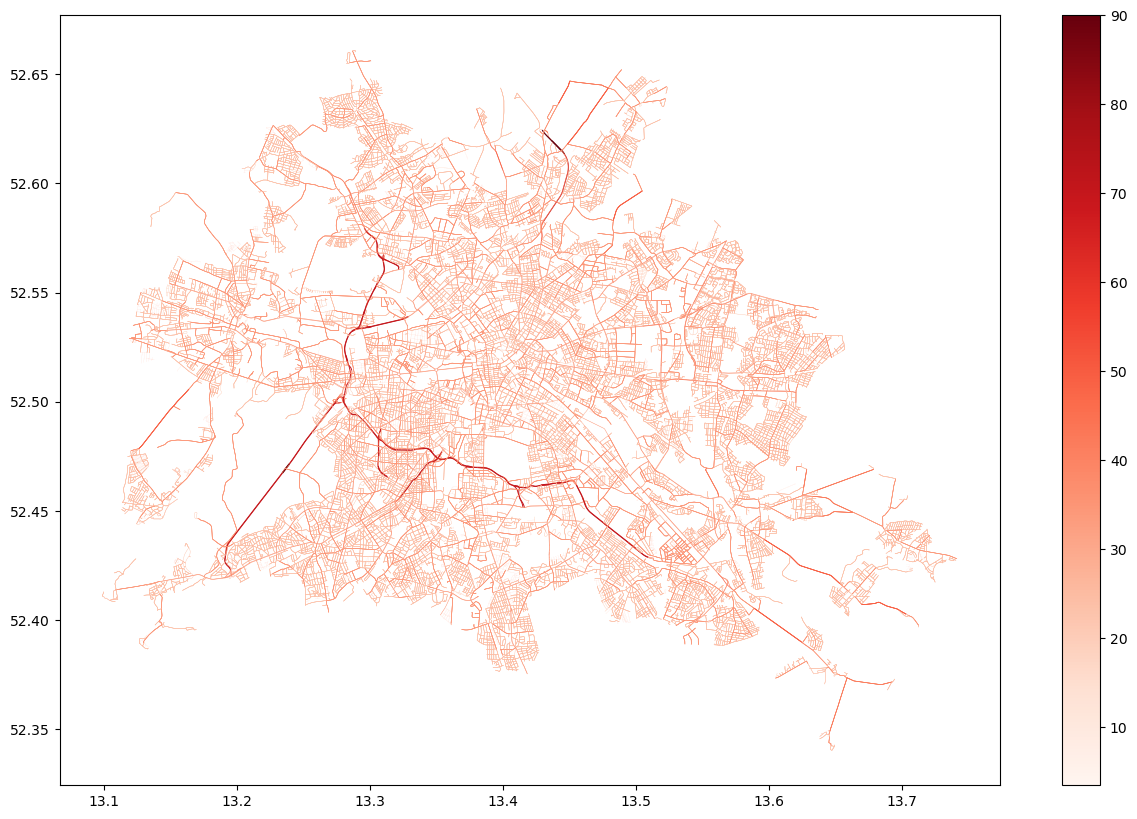

In [39]:
# Plot that shows average speeds on specific roads
if show_plots:
    fig, ax = plt.subplots(nrows=1, figsize=(16, 10))
    sm.road_links.plot(ax=ax, cmap="Reds", column='avspeed',
                       linewidth=(sm.road_links['avspeed']/100), legend=True)
    plt.savefig(output_path + 'plots/road_speed.png', dpi=300)

In [40]:
# Create the time LoS column for cars (it's already there for PT from the GTFS feeds)
assert sm.road_links['length'].notna().all()
sm.road_links['time'] = sm.road_links['length'] / \
    (sm.road_links['avspeed'] * 1000/(60**2))

In [42]:
# If we want to compute walking paths on road links, we need a time for that too
sm.road_links['walk_time'] = sm.road_links['length'] / (5/3.6)  # walk with 5 km/h per hour

# Pathfinding

Next, we want to create a table of OD-relations for different modes, each, being representative for the performance of a specific mode on a specific OD pair.

Quetzal has multiple options for path finding, seperated into one function wrapper for road and one for PT. They create the `car_los` and `pt_los tables`, respectively.

For road transport, quetzal can simply compute one shortest path per OD pair or multiple ones if you had the capacities and volumes already saved in the model (comes from the assignment step at the very end). So, we just compute one path for now (`all_or_nothing=True`) <mark>new version: (method='aon')<mark>

The PT pathfinder has two relevant attributes: `broken_modes` and `broken_routes`. If both are `False`, the pathfinder just searches for the shortest path between every OD pair, considering all PT modes and routes. If `broken_modes=True`, the pathfinder searches shortest paths for every possible mode combination. If `broken_routes=True`, the pathfinder searches shortest paths for every possible route combination. 
Additionally you can decide whether walking connections shall be done on roadsides or not with the `walk_on_road` parameter (question of computation time).

In [43]:
sm.zones.sample(1)

,BEZIRKSNAM,PLANUNGSRA,FLAECHENGR,pop,popCentroidLat,popCentroidLon,emp,pois,poiCentroidLat,poiCentroidLon,Education,Shopping,"Visit to authorities, doctor",Service facility (e.g. post office. bank. hairdresser),"Culture, theater, cinema",Restaurant/pub/cafe,"Recreation, Sports",privateCarOwnership,geometry
index,,,,,,,,,,,,,,,,,,,
04041238,Charlottenburg-Wilmersdorf,Kissinger Straße,646584.3,6005,52.479516,13.291366,3446.358486,38,52.478966,13.290574,1238.118622,1286.739954,177.148818,227.734411,126.329429,327.062189,751.904044,2218,"POLYGON ((13.28132 52.47681, 13.28143 52.47690..."


## Road pathfinder

In [55]:
# Make sure zones are properly indexed
if not str(sm.zones.index[0]).startswith('zone_'):
    sm.zones.index = ['zone_'+str(i) for i in sm.zones.index]

In [47]:
# Reindex road links
sm.road_links.index = ['rl_'+str(i) for i in sm.road_links.index]
# Drop duplicated links
sm.road_links = sm.road_links.drop_duplicates(subset=['a', 'b'])

In [56]:
# Simple road pathfinder
sm.step_road_pathfinder(method='aon')
#sm.step_road_pathfinder(method='aon') # for newer quetzal versions
# restructure car_los
sm.analysis_car_los()
# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm.car_los['length'] = sm.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))
# add the route type for sake of consistency
sm.analysis_car_route_type()
sm.car_los['all_walk'] = False
sm.car_los['ntransfers'] = 0
sm.car_los.sample()

self.volumes does not exist. od generated with self.zones


,origin,destination,time,path,gtime,node_path,link_path,ntlegs,length,route_types,route_type,all_walk,ntransfers
74313,zone_05010102,zone_11010308,2664.65442,"[zone_05010102, 247345108, 247342701, 33017703...",2664.65442,"[247345108, 247342701, 33017703, 194539308, 71...","[rl_44122, rl_44083, rl_29608, rl_41484, rl_56...","[(zone_05010102, 247345108), (30690589, zone_1...",24927.574,"(car,)",car,False,0


In [57]:
len(sm.car_los)

200704

In [59]:
# drop inner-zonal connections
sm.car_los = sm.car_los.loc[sm.car_los['time']>0]
len(sm.car_los)

200256

## Public transport

In [60]:
# set broken_modes=False if only unique best path matters
# Otherwise choose mode combinations
sm.step_pt_pathfinder(broken_modes=False,
                      broken_routes=False,
                      walk_on_road=False,
                      path_analysis=False,
                      boarding_time=None,
                      time_expanded=True)

start publicpathfinder
path_analysis


In [61]:
# drop duplicates
print(sm.pt_los.shape)
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
print(sm.pt_los.shape)

(200704, 6)
(200704, 6)


In [62]:
# analyse the path
sm.analysis_pt_los()

path_analysis: 100%|████████████████████████████████████████████████████████| 200704/200704 [00:18<00:00, 10863.04it/s]


In [63]:
# Add route types to the paths
# The mode that appears first in the hierarchy is assigned as
# main mode, if there is more than one route_type used on the path
hierarchy = ['bike', 'rail', 'subway', 'tram', 'bus', 'ferry', 'walk']
sm.analysis_pt_route_type(hierarchy)

In [64]:
# Add columns 'time' and 'length'
sm.pt_los['time'] = sm.pt_los['gtime']
sm.pt_los['length'] = sm.pt_los['length_link_path']
sm.pt_los.sample(1)

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type,time,length
166455,zone_10020519,zone_07010104,3442.908431,"(zone_10020519, node_de:11000:900175007::8, no...",best_path,False,"[node_de:11000:900175007::1, node_de:11000:900...","[node_de:11000:900175001::1, node_de:11000:900...","[node_de:11000:900175007::8, node_de:11000:900...","[link_20066, link_20067, link_20068, link_2006...",...,"[link_20066, link_22942, link_991, link_440, l...","[link_20069, link_22946, link_995, link_441, l...",False,4,1944.0,34261.010406,"(rail, subway)",rail,3442.908431,34261.010406


In [65]:
# PT_LOS: Ditch unneccessary columns
to_drop = ['alighting_links','alightings','boarding_links','boardings',
           'length_link_path','transfers', 'footpaths',
           'pathfinder_session','gtime','reversed', 'broken_modes']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')
sm.pt_los.shape

(200704, 13)

In [67]:
# drop inner-zonal connections
sm.pt_los = sm.pt_los.loc[sm.pt_los['time']>0]
len(sm.pt_los)

200256

## Bike

In [68]:
bike_speed = 15 / 3.6 # m/s

In [69]:
# Copy car_los as bike LoS table
sm.bike_los = sm.car_los.copy()
sm.bike_los['route_type'] = 'bike'
sm.bike_los['route_types'] = [('bike',) for i in sm.bike_los.index]
sm.bike_los['time'] = sm.bike_los['length'] / bike_speed

# Save model

<Axes: >

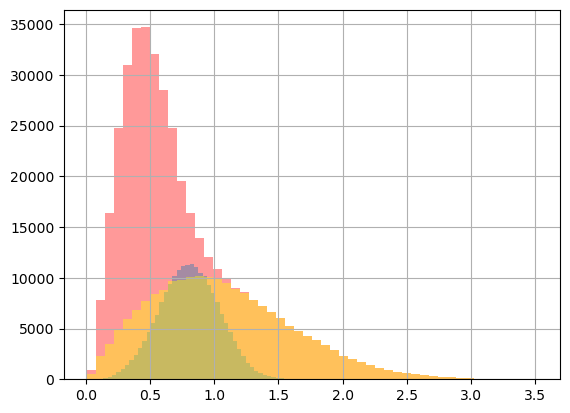

In [74]:
# mode time in hours
(sm.bike_los['time'] / 3600).hist(bins=50, color='yellow', alpha=.4,
                                  ax=(sm.pt_los['time'] / 3600).hist(bins=50, alpha=.4,
                                                                     ax=(sm.car_los['time']/3600).hist(bins=50, color='red', alpha=.4)))

In [71]:
# Merge bicycle with car table
sm.car_los = pd.concat([sm.car_los, sm.bike_los])

In [72]:
sm.to_zippedpickles(model_path + 'los', only_attributes=['car_los', 'pt_los'])

bike_los: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]
